### Visualizing the distribution of the observations

### Load the required libraries

In [68]:
sc.stop()

In [69]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
#file_index='BBBSBBBB'
file_index='SSSBSBBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12152
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   2804.2| 38.4333|-119.3667|       TMAX|USS0019L17S|     4|[80 CD 30 D5 80 C...|1990.0|SSSBSBBS|
|   2804.2| 38.4333|-119.3667|       TMAX|USS0019L17S|     0|[E0 55 F0 56 00 0...|1991.0|SSSBSBBS|
|   2804.2| 38.4333|-119.3667|       TMAX|USS0019L17S|     1|[A0 53 A0 53 80 C...|1992.0|SSSBSBBS|
|   2804.2| 38.4333|-119.3667|       TMAX|USS0019L17S|    17|[80 D1 40 D6 00 C...|1993.0|SSSBSBBS|
|   2804.2| 38.4333|-119.3667|       TMAX|USS0019L17S|     1|[80 54 40 56 A0 5...|1994.0|SSSBSBBS|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USS0019L17S')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USS0019L17S'
18 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   2804.2| 38.4333|-119.3667|       PRCP|USS0019L17S|     2|[00 00 00 00 00 0...|1979.0|SSSBSBBS|
|   2804.2| 38.4333|-119.3667|       PRCP|USS0019L17S|     2|[00 00 00 00 90 5...|1980.0|SSSBSBBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(18, 365)

### Script for plotting yearly plots

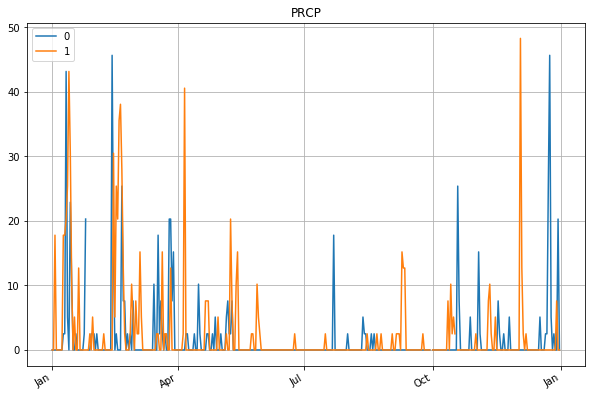

In [5]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');
fig.savefig('report_figures/PRCP.png')

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [16]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
    return fig
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


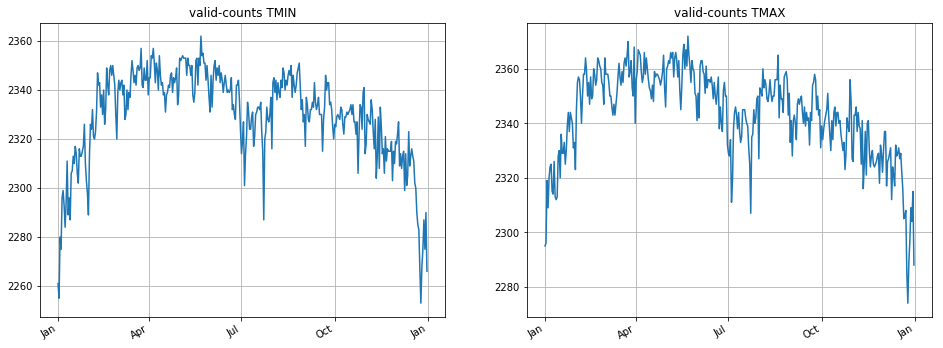

In [7]:
plot_pair(['TMIN','TMAX'],plot_valid)

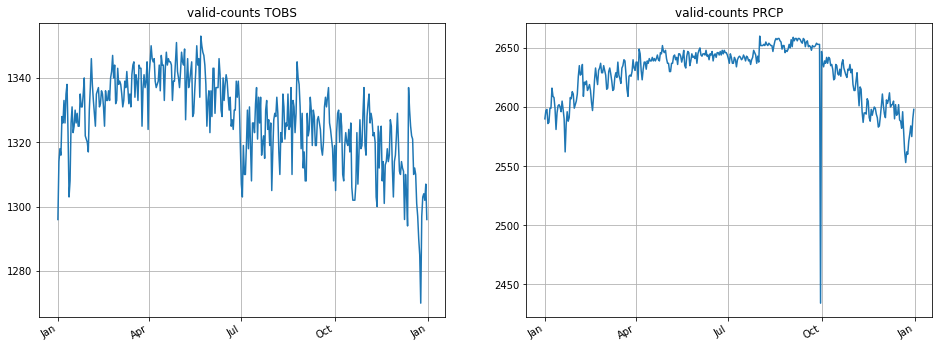

In [8]:
plot_pair(['TOBS','PRCP'],plot_valid)

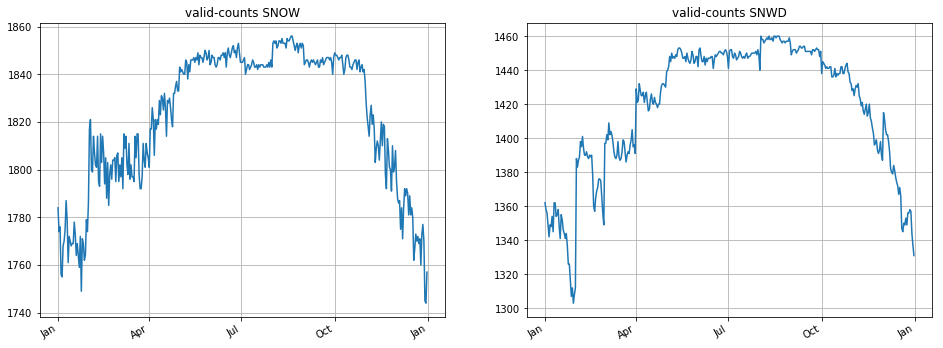

In [9]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [74]:
def plot_mean_std(m,fig,axis):
    if m in ['TMIN','TMAX','TOBS','PRCP']:
        mean=STAT[m]['Mean']/10.
        std=np.sqrt(STAT[m]['Var'])/10.
    else:
        mean=STAT[m]['Mean']
        std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,labels=['mean-std','mean','mean+std'],title='Mean+-std   '+m)
    

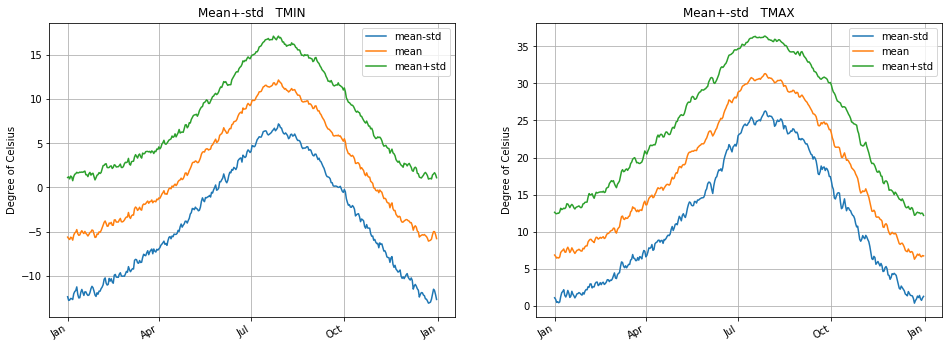

In [75]:
tmin_tmax = plot_pair(['TMIN','TMAX'],plot_mean_std)

ax = tmin_tmax.axes
for i in ax:
    i.set_ylabel('Degree of Celsius')

#tmin_tmax
tmin_tmax.savefig("report_figures/TMIN,TMAX.png")

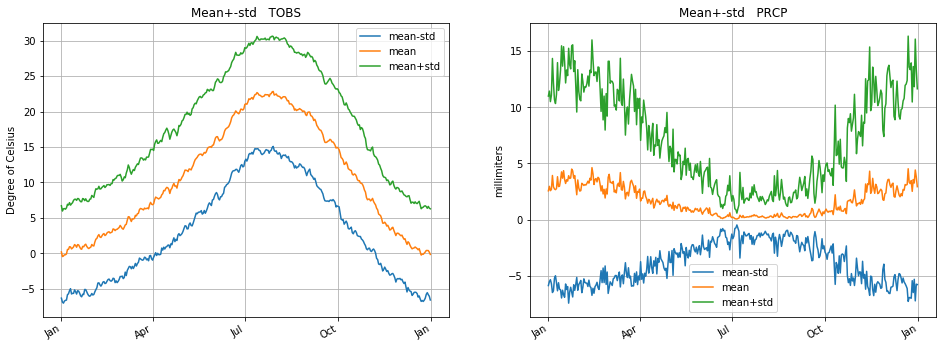

In [76]:
tobs_prcp= plot_pair(['TOBS','PRCP'],plot_mean_std)
#add ylabel 
ax = tobs_prcp.axes
ax[0].set_ylabel('Degree of Celsius')
ax[1].set_ylabel('millimiters')
    
#only save prcp mean std 
ax2 = ax[1]
extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
tobs_prcp.savefig('report_figures/prcp_mean_std.png', bbox_inches=extent.expanded(1.2, 1.2))



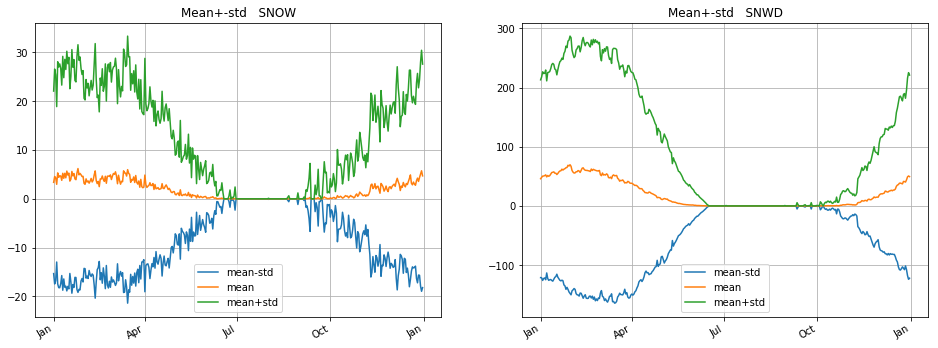

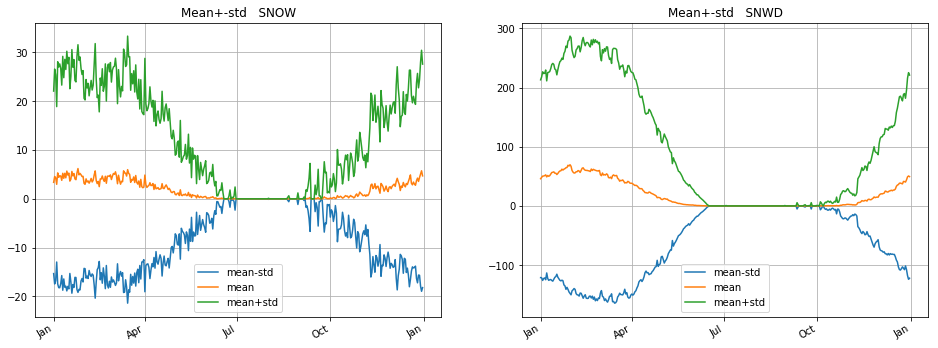

In [92]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)


### plotting top 3 eigenvectors

In [77]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

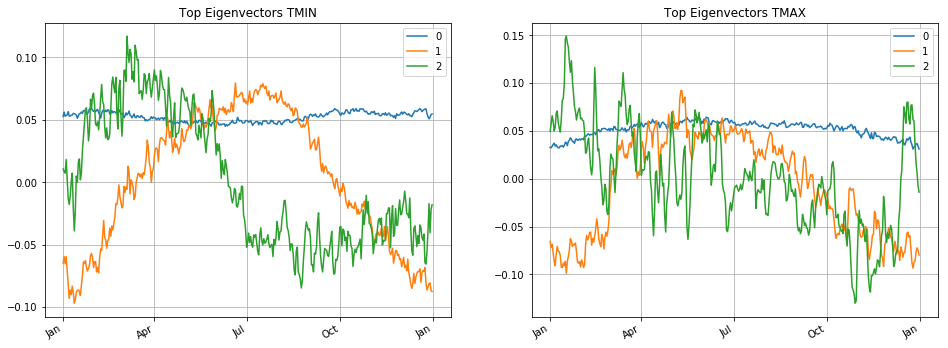

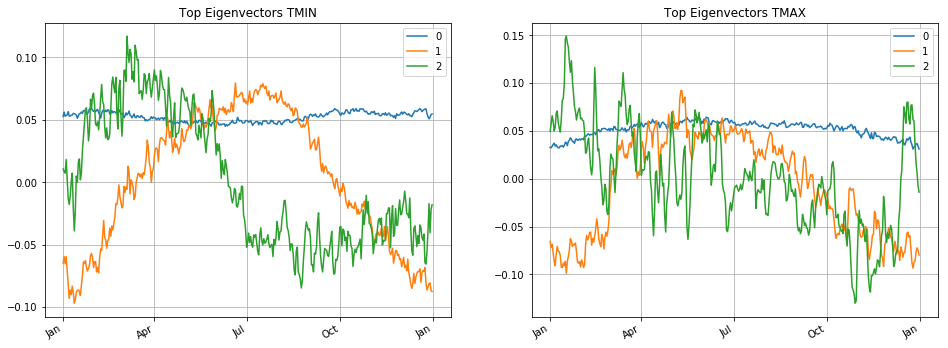

In [78]:
plot_pair(['TMIN','TMAX'],plot_eigen)

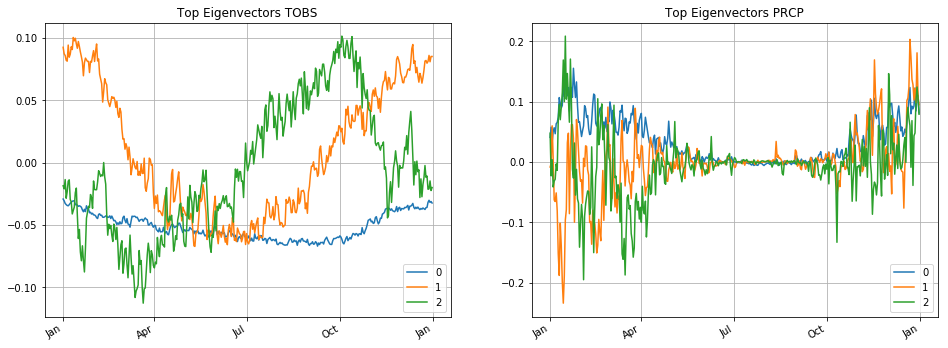

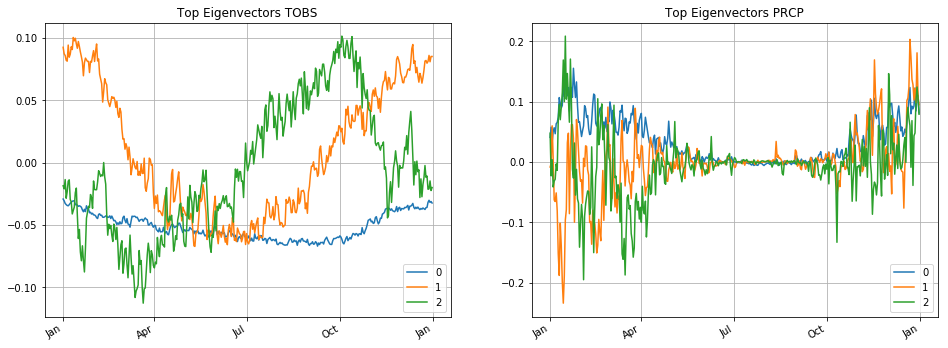

In [79]:
plot_pair(['TOBS','PRCP'],plot_eigen)

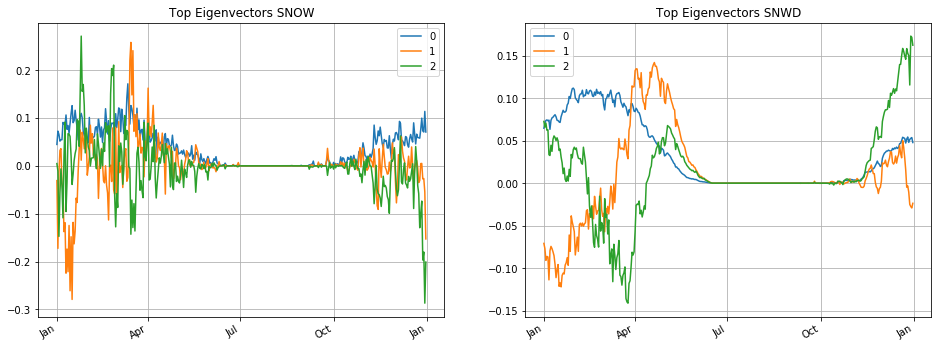

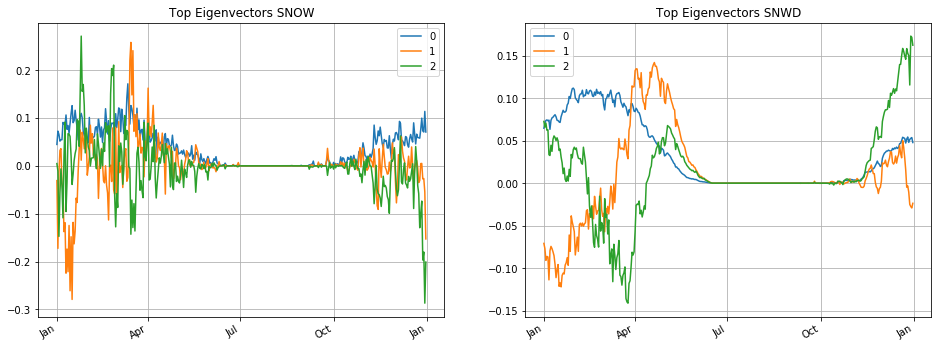

In [80]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [81]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

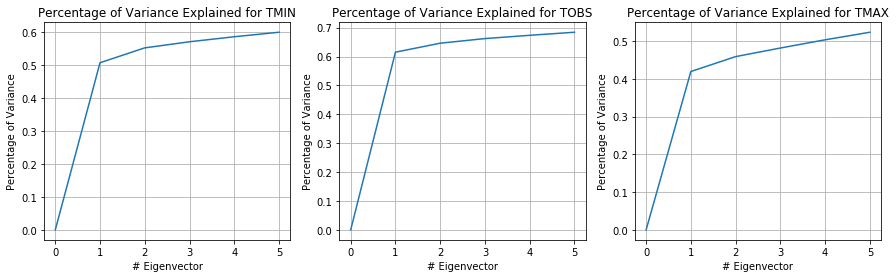

In [86]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1
f.savefig('report_figures/VarExplained1.png')

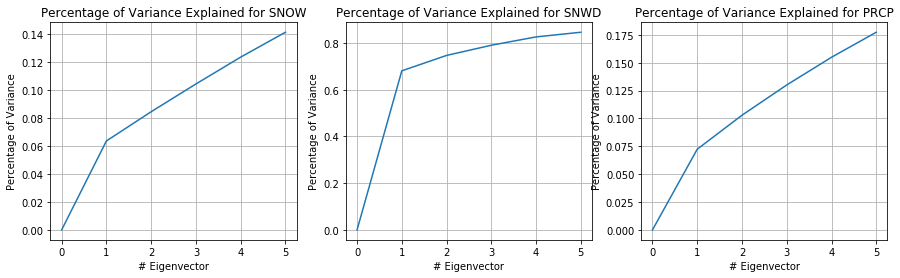

In [87]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 
f.savefig('report_figures/VarExplained2.png')

In [88]:
sc.stop()